# COMBIMACION DE LOS DOS MODELOS

Comprobamos si los dos modelos combinados darian buena respuesta a un dataset de otra piscina con diferentes condiciones

In [31]:
import joblib
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Cargar
modelo_d7 = joblib.load('modelo_random_forest_D7.pkl')
modelo_d1 = joblib.load('modelo_random_forest_D1.pkl')

print("Modelos cargados exitosamente.")

Modelos cargados exitosamente.


In [32]:
try:
    base_path = r"..\DATA\Processed_Data"
    df = pd.read_csv(os.path.join(base_path, 'datos_limpios_Device06.csv'))
    print(f"Datos cargados exitosamente")
    print(df.shape)
    print(df.head(2).to_string())
    
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)
    df.sort_index(inplace=True)
except Exception as e:
    print(f'Se ha producido un error: {e}')

Datos cargados exitosamente
(2953, 7)
      Device                 Time   PH  ORP  Salinity  Temperature  Flow status
0  Device 06  2024-01-18 05:18:58  7.3  784      3683           17            1
1  Device 06  2024-01-18 04:03:36  7.4  774      3911           17            1


In [33]:
for i in range(1, 4):  
    df[f'PH_lag_{i}'] = df['PH'].shift(i)
    df[f'ORP_lag_{i}'] = df['ORP'].shift(i)

# Crear la columna 'Predict_Cl' no existe
setpoint = 640  
df['Predict_Cl'] = df['ORP'].apply(lambda x: 1 if x < setpoint else 0)

df.dropna(inplace=True)
X_nuevo = df[['ORP', 'Salinity', 'Temperature', 'PH_lag_1', 'PH_lag_2', 'PH_lag_3', 
              'ORP_lag_1', 'ORP_lag_2', 'ORP_lag_3', 'Predict_Cl']]

In [34]:
# Escalar los datos de Device 06 que ya fueron tratados en el otro jupyter
scaler = StandardScaler()
X_nuevo_scaled = scaler.fit_transform(X_nuevo)

In [35]:
# Predicciones de ambos modelos
predicciones_d7 = modelo_d7.predict(X_nuevo_scaled)
predicciones_d1 = modelo_d1.predict(X_nuevo_scaled)

print("Predicciones realizadas con ambos modelos.")

Predicciones realizadas con ambos modelos.


In [50]:
# Promediao
predicciones_combinadas = np.mean([predicciones_d7, predicciones_d1], axis=0)

print("Predicciones combinadas de ambos modelos.")

Predicciones combinadas de ambos modelos.


MSE combinado: 0.0156
R² combinado: -0.8053


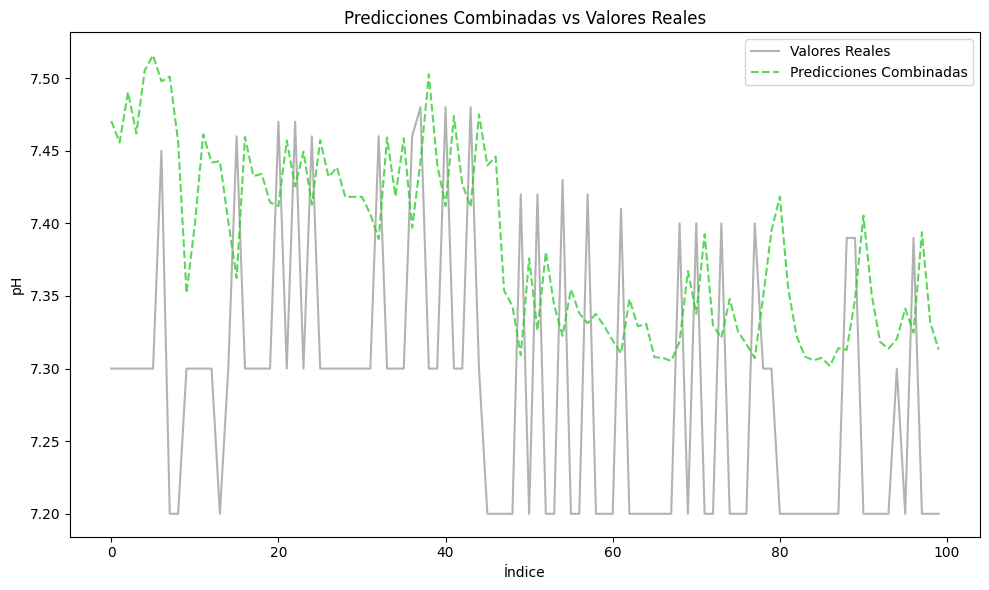

In [51]:
y_real = df['PH']
# Calcular MSE
mse_combinado = mean_squared_error(y_real, predicciones_combinadas)
r2_combinado = r2_score(y_real, predicciones_combinadas)

print(f"MSE combinado: {mse_combinado:.4f}")
print(f"R² combinado: {r2_combinado:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(y_real.values[:100], label='Valores Reales', color='grey', alpha=0.6)
plt.plot(predicciones_combinadas[:100], label='Predicciones Combinadas', linestyle='--', color='#32cd32', alpha=0.8)
plt.title(f'Predicciones Combinadas vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('pH')
plt.legend()
plt.tight_layout()
plt.show()

# Modelos individuales

A ver si alguno de los modelos se comporta mejor en particular

In [52]:
# Calcular MSE y R² para ambos modelos
mse_d7 = mean_squared_error(y_real, predicciones_d7)
r2_d7 = r2_score(y_real, predicciones_d7)

mse_d1 = mean_squared_error(y_real, predicciones_d1)
r2_d1 = r2_score(y_real, predicciones_d1)

print(f"Device 07 - MSE: {mse_d7:.4f}, R²: {r2_d7:.4f}")
print(f"Device 01 - MSE: {mse_d1:.4f}, R²: {r2_d1:.4f}")

Device 07 - MSE: 0.0076, R²: 0.1196
Device 01 - MSE: 0.0381, R²: -3.4098


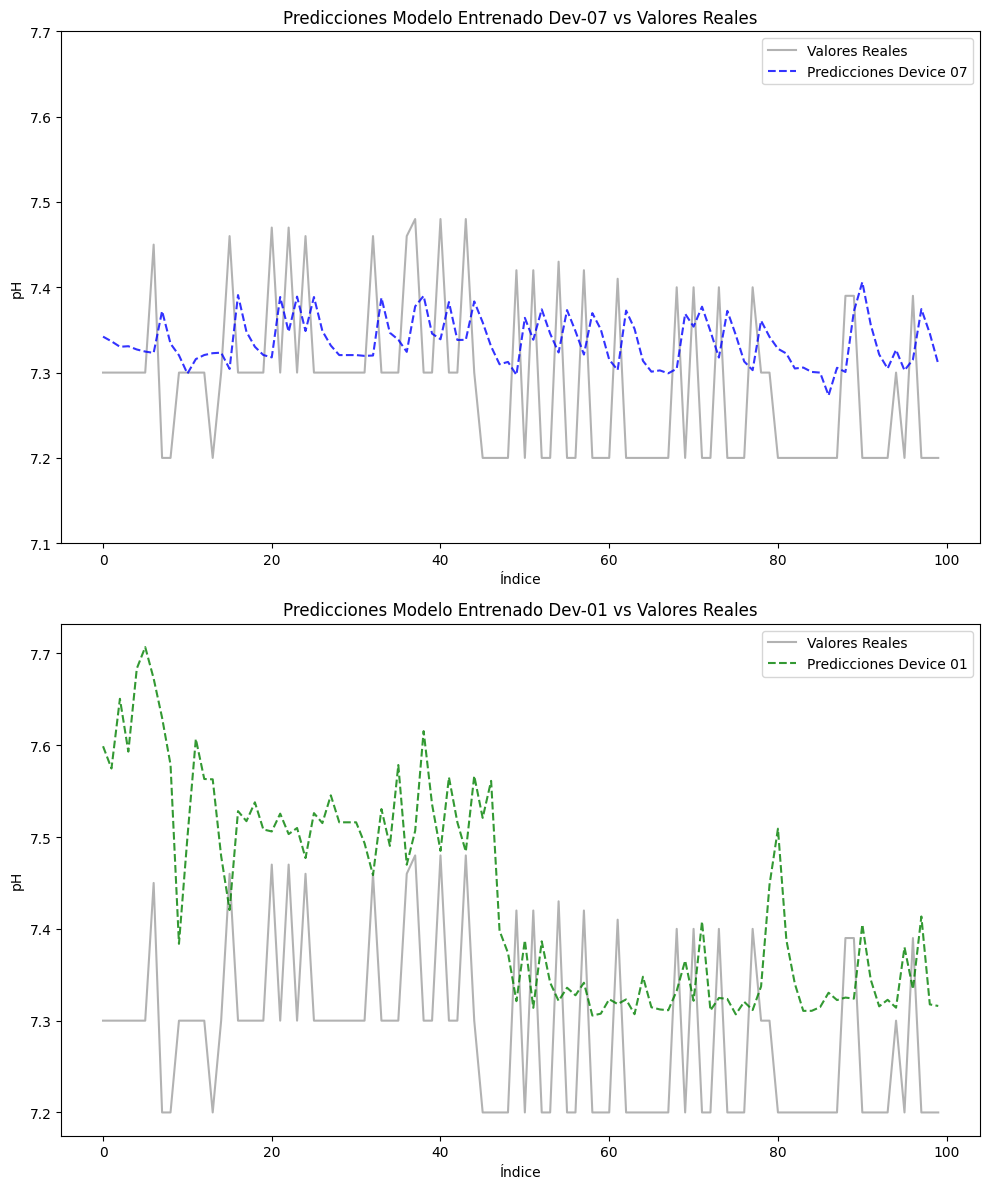

In [63]:
# Visualización de Predicciones vs Valores Reales
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Gráfica usando el modelo entrenado del Device 07
ax[0].plot(y_real.values[:100], label='Valores Reales', color='grey', alpha=0.6)
ax[0].plot(predicciones_d7[:100], label='Predicciones Device 07', linestyle='--', color='blue', alpha=0.8)
ax[0].set_title(f'Predicciones Modelo Entrenado Dev-07 vs Valores Reales')
ax[0].set_xlabel('Índice')
ax[0].set_ylabel('pH')
ax[0].set_ylim([7.1, 7.7]) 
ax[0].legend()

# Gráfica usando el modelo entrenado del Device 01
ax[1].plot(y_real.values[:100], label='Valores Reales', color='grey', alpha=0.6)
ax[1].plot(predicciones_d1[:100], label='Predicciones Device 01', linestyle='--', color='green', alpha=0.8)
ax[1].set_title(f'Predicciones Modelo Entrenado Dev-01 vs Valores Reales')
ax[1].set_xlabel('Índice')
ax[1].set_ylabel('pH')
ax[0].set_ylim([7.1, 7.7]) 
ax[1].legend()

plt.tight_layout()
plt.show()